In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection
c:/Users/Admin/Data/ads_fraud_detection


In [2]:
save_dir=f"{exps_dir}/exp1/exp_gan"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [3]:
# feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
# feature_selection = {key: value for key, value in feature_selection.item().items()}
# feature_selection

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [4]:
# bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
# rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
# svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [5]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
data_train=pd.read_excel(f'{save_dir}/data_train.xlsx')
category_columns=dict(np.load(f'{exps_dir}/exp1/columns_dtype.npz',allow_pickle=True))['category_columns']
numeric_columns=dict(np.load(f'{exps_dir}/exp1/columns_dtype.npz',allow_pickle=True))['numeric_columns']
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.6555772994129159, 1: 2.106918238993711}

In [6]:
data_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,day_policy_bind_date,month_policy_bind_date,year_policy_bind_date,day_incident_date,month_incident_date,year_incident_date,fraud_reported
0,1,0,3,1,0,-1.627744,0,1,2,11,0,2,-0.484993,0.713114,3,1,1,1,6,164,1,2,2,2,2,0,1.233197,0.520014,-0.153639,0.754373,13,10,1,0.884193,-1.132441,0.750862,0.916440,0.672189,0,1
1,1,0,2,2,2,-0.160937,0,1,0,12,15,3,0.996056,0.970481,0,3,1,1,6,3,2,2,0,0,1,1,0.477301,-0.205781,-0.185383,0.770711,11,19,2,0.241321,1.258650,-1.158249,1.856570,-0.947412,0,0
2,1,0,43,2,0,0.859377,0,1,2,11,2,1,-0.520024,-0.319395,2,1,1,0,30,961,2,0,1,1,1,0,-0.302223,-1.005916,-0.573318,0.669505,12,33,2,-0.063070,1.226571,-1.456828,-0.646883,0.503329,0,1
3,1,0,2,2,2,0.676959,6,0,4,9,18,0,0.027774,-1.010058,3,0,1,4,6,6,1,0,0,1,2,1,-1.901321,-1.428810,-1.482357,-1.911094,0,23,2,-0.660687,-1.042293,-1.433827,-0.697405,0.953085,0,0
4,1,0,0,1,1,-1.770734,0,1,2,11,6,4,1.270697,0.970481,0,2,2,0,4,1,0,2,0,1,1,1,0.249230,-0.612776,0.358110,0.416329,8,24,2,0.579574,-0.179439,-1.020460,-1.393943,-0.947412,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,0,0,0,2,1,-0.563508,0,0,5,6,15,0,-0.919382,-1.171223,0,3,1,0,1,1,2,2,2,1,3,0,-0.183764,-0.451205,0.683383,-0.316910,4,27,1,-1.111691,1.258650,1.597528,-0.349136,0.953085,0,0
1018,0,2,1,0,1,1.141078,0,0,1,5,2,0,-0.919382,-1.708440,0,1,1,3,1,6,0,2,2,1,1,1,0.913711,0.029417,1.650967,0.846802,7,36,1,0.015819,1.546268,0.770795,0.579582,0.953085,0,0
1019,1,2,20,1,2,0.276578,0,0,0,9,13,1,2.195559,-1.162763,2,1,1,2,24,126,1,2,1,0,3,0,1.016387,-0.877331,1.864349,0.737650,0,13,0,0.764304,1.459380,1.077091,-2.011146,-1.394737,0,1
1020,1,0,1,2,2,-0.455091,6,0,4,4,7,1,-0.919382,-0.963500,2,1,2,0,4,4,0,0,0,2,0,0,0.851096,0.833181,0.860431,0.754216,3,32,0,0.917827,0.108179,-0.331516,0.115223,-0.947412,0,0


In [7]:
label_encoders = {}
for column in category_columns:
    label_encoder = LabelEncoder()
    data_train[column] = label_encoder.fit_transform(data_train[column])
    label_encoders[column] = label_encoder  # Lưu trữ label encoder nếu cần sau này

scaler = StandardScaler()
data_train[numeric_columns] = scaler.fit_transform(data_train[numeric_columns])
data_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,day_policy_bind_date,month_policy_bind_date,year_policy_bind_date,day_incident_date,month_incident_date,year_incident_date,fraud_reported
0,1,0,3,1,0,-1.624586,0,1,2,11,0,2,-0.483670,0.734645,3,1,1,1,6,51,1,2,2,2,2,0,1.247102,0.514454,-0.133556,0.745474,13,10,1,0.867817,-1.092895,0.726705,0.922726,0.693469,0.0,1
1,1,0,2,2,2,-0.130628,0,1,0,12,15,3,0.976974,0.992657,0,3,1,1,6,3,2,2,0,0,1,1,0.482836,-0.214728,-0.165451,0.761801,11,19,2,0.221615,1.272143,-1.172593,1.862056,-0.905536,0.0,0
2,1,0,43,2,0,0.908572,0,1,2,11,2,1,-0.518218,-0.300451,2,1,1,0,30,360,2,0,1,1,1,0,-0.305321,-1.018597,-0.555234,0.660662,12,33,2,-0.084352,1.240413,-1.469636,-0.639267,0.526756,0.0,1
3,1,0,2,2,2,0.722778,6,0,4,9,18,0,0.022032,-0.992845,3,0,1,4,6,6,1,0,0,1,2,1,-1.922128,-1.443464,-1.468603,-1.918237,0,23,2,-0.685066,-1.003729,-1.446754,-0.689746,0.970792,0.0,0
4,1,0,0,1,1,-1.770223,0,1,2,11,6,4,1.247830,0.992657,0,2,2,0,4,1,0,2,0,1,1,1,0.252238,-0.623622,0.380632,0.407653,8,24,2,0.561620,-0.150277,-1.035512,-1.385692,-0.905536,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,0,0,0,2,1,-0.540650,0,0,5,6,15,0,-0.912074,-1.154414,0,3,1,0,1,1,2,2,2,1,3,0,-0.185551,-0.461297,0.707454,-0.325103,4,27,1,-1.138406,1.272143,1.569018,-0.341773,0.970792,0.0,0
1018,0,2,1,0,1,1.195488,0,0,1,5,2,0,-0.912074,-1.692977,0,1,1,3,1,6,0,2,2,1,1,1,0.924078,0.021568,1.679647,0.837842,7,36,1,-0.005055,1.556627,0.746535,0.586155,0.970792,0.0,0
1019,1,2,20,1,2,0.314985,0,0,0,9,13,1,2.159949,-1.145933,2,1,1,2,24,37,1,2,1,0,3,0,1.027891,-0.889411,1.894045,0.728762,0,13,0,0.747307,1.470686,1.051256,-2.002369,-1.347173,0.0,1
1020,1,0,1,2,2,-0.430227,6,0,4,4,7,1,-0.912074,-0.946170,2,1,2,0,4,4,0,0,0,2,0,0,0.860769,0.829082,0.885345,0.745317,3,32,0,0.901625,0.134207,-0.350110,0.122191,-0.905536,0.0,0


In [8]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse_output=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(330, 2) (1022, 2)


In [9]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(330, 2)


In [10]:
x_test.shape

(330, 39)

In [11]:
x_train.shape

(1022, 39)

In [12]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [14]:
# dice_loss=tf.keras.losses.Dice(
#     reduction='sum_over_batch_size', name='dice'
# )

In [15]:
print(x_train.shape[1])

39


#### * Xây dựng model:

#### * Xây dựng Stacked_model:

In [16]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [17]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_rosampled, y_rosampled = ros.fit_resample(data_train.drop(columns=['fraud_reported']), data_train['fraud_reported'])
X_rosampled = pd.DataFrame(X_rosampled)
y_rosampled = pd.DataFrame(y_rosampled)
oversampling_sample=pd.concat([X_rosampled, y_rosampled], axis=1)    

In [18]:
oversampling_sample.dtypes

months_as_customer               int64
age                              int64
policy_state                     int64
policy_csl                       int64
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_sex                      int64
insured_education_level          int64
insured_occupation               int64
insured_hobbies                  int64
insured_relationship             int64
capital-gains                  float64
capital-loss                   float64
incident_type                    int64
collision_type                   int64
incident_severity                int64
authorities_contacted            int64
incident_state                   int64
incident_city                    int64
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage                  int64
bodily_injuries                  int64
witnesses                        int64
police_report_available  

In [19]:
from sdv.metadata import SingleTableMetadata
metadata_sync = SingleTableMetadata()
metadata_sync.detect_from_dataframe(data=oversampling_sample)

In [20]:
metadata_sync.update_column(
    column_name="policy_state",
    sdtype="categorical" ,
)
metadata_sync.update_column(
    column_name="incident_state",
    sdtype="categorical" ,
)
metadata_sync.update_column(
    column_name="incident_city",
    sdtype="categorical" ,
)

In [21]:
metadata_sync

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "months_as_customer": {
            "sdtype": "categorical"
        },
        "age": {
            "sdtype": "categorical"
        },
        "policy_state": {
            "sdtype": "categorical"
        },
        "policy_csl": {
            "sdtype": "categorical"
        },
        "policy_deductable": {
            "sdtype": "categorical"
        },
        "policy_annual_premium": {
            "sdtype": "numerical"
        },
        "umbrella_limit": {
            "sdtype": "categorical"
        },
        "insured_sex": {
            "sdtype": "categorical"
        },
        "insured_education_level": {
            "sdtype": "categorical"
        },
        "insured_occupation": {
            "sdtype": "numerical"
        },
        "insured_hobbies": {
            "sdtype": "numerical"
        },
        "insured_relationship": {
            "sdtype": "categorical"
        },
        "capital-gains": 

In [22]:
oversampling_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1022 non-null   int64  
 1   age                          1022 non-null   int64  
 2   policy_state                 1022 non-null   int64  
 3   policy_csl                   1022 non-null   int64  
 4   policy_deductable            1022 non-null   int64  
 5   policy_annual_premium        1022 non-null   float64
 6   umbrella_limit               1022 non-null   int64  
 7   insured_sex                  1022 non-null   int64  
 8   insured_education_level      1022 non-null   int64  
 9   insured_occupation           1022 non-null   int64  
 10  insured_hobbies              1022 non-null   int64  
 11  insured_relationship         1022 non-null   int64  
 12  capital-gains                1022 non-null   float64
 13  capital-loss      

In [23]:
from sdv.single_table import CTGANSynthesizer
import pandas as pd
import pickle


gan_synthesizer = CTGANSynthesizer(metadata_sync,
                                   enforce_min_max_values=True,  
                                   enforce_rounding=True,
                                   verbose=True)

gan_synthesizer.fit(oversampling_sample)


gan_synthesizer.save(filepath=f'{save_dir}/gan_synthesizer_exp.pkl')




Gen. (-1.19) | Discrim. (0.04): 100%|██████████| 300/300 [01:25<00:00,  3.50it/s] 


In [24]:
data_train.policy_state.value_counts()

policy_state
0     231
2     228
1     214
25     17
48     12
42     12
43     11
22     11
40     11
4      11
8      11
49     10
32      9
12      9
35      9
5       9
13      9
34      8
36      8
9       8
44      8
24      8
18      8
47      8
10      7
23      7
21      7
29      7
30      7
17      7
26      7
20      7
6       6
19      6
28      6
3       6
14      6
38      6
15      5
39      5
16      5
37      5
45      5
33      4
27      4
41      4
46      4
11      4
7       3
31      2
Name: count, dtype: int64

In [25]:
y_train

,fraud_reported
0,1
1,0
2,1
3,0
4,1
...,...
1017,0
1018,0
1019,1
1020,0


In [26]:
import numpy as np

def generate_augmented_batch(batch_size):
    """Hàm sinh dữ liệu mới từ GAN và kết hợp với dữ liệu thật."""
    new_data = gan_synthesizer.sample(num_rows=batch_size)
    # test_data = gan_synthesizer.sample(num_rows=300)
    # print(new_data)
    
    y_add = oneHot(new_data["fraud_reported"].values)
    # y_test_add = oneHot(test_data["fraud_reported"].values)
    # print(X_augmented.shape)
    # print(y_augmented.shape)
    # print(new_data.info())
    # Kết hợp dữ liệu
    X_augmented = np.vstack([x_train, new_data.drop(columns=["fraud_reported"]).values])
    y_augmented = np.vstack([y_train_onehot, y_add])
    # X_test_augmented = np.vstack([x_test, test_data.drop(columns=["fraud_reported"]).values])
    # y_test_augmented = np.vstack([y_test_onehot, y_test_add])
  
    return X_augmented, y_augmented,x_test,y_test_onehot


In [27]:
# new_data = gan_synthesizer.sample(num_rows=10)
# new_data

In [28]:
from tensorflow.keras import regularizers
from tabnet_keras.models import TabNetClassifier

# Định nghĩa tham số regularization
l2_reg = 0.001

learning_rate=0.1
tabnet_params = {
    "decision_dim": 512,
    "attention_dim": 512,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}



### Classification
model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)
# model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', 
#     kernel_regularizer=l2(0.01), **tabnet_params)
# model.compile(loss = 'categorical_crossentropy', optimizer = )
# model.fit(x_train, y_train, epochs = 100, batch_size = 1024)
# model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(learning_rate=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

# checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5",monitor='val_accuracy', verbose = 1, save_best_only=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=0.000001,
    verbose=1,
)


In [29]:
y_train_onehot

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [30]:
# model.load_weights(f'{save_dir}/tabnet_model.h5')

In [31]:
class_weights_dict

{0: 0.6555772994129159, 1: 2.106918238993711}

In [32]:
batch_size = 1022
for epoch in range(150):  # Giới hạn số epoch
    X_train_aug, y_train_aug, X_test_aug, y_test_aug = generate_augmented_batch(batch_size=10000)
    print(epoch)
    model.fit(X_train_aug, y_train_aug,validation_data=(X_test_aug, y_test_aug), epochs=100, batch_size=64, verbose=1,callbacks=[early_stopping, lr_scheduler], class_weight=class_weights_dict)


0
Epoch 1/100
173/173 [==============================] - 56s 132ms/step - loss: 1.2630 - accuracy: 0.5471 - f1_score: 0.3607 - val_loss: 1.5337 - val_accuracy: 0.2667 - val_f1_score: 0.2199 - lr: 0.1000
Epoch 2/100
173/173 [==============================] - 22s 128ms/step - loss: 0.7389 - accuracy: 0.5513 - f1_score: 0.3563 - val_loss: 1.2297 - val_accuracy: 0.2697 - val_f1_score: 0.2253 - lr: 0.1000
Epoch 3/100
173/173 [==============================] - 22s 130ms/step - loss: 0.7338 - accuracy: 0.5509 - f1_score: 0.3560 - val_loss: 1.2364 - val_accuracy: 0.2667 - val_f1_score: 0.2199 - lr: 0.1000
Epoch 4/100
173/173 [==============================] - 22s 130ms/step - loss: 0.7312 - accuracy: 0.5510 - f1_score: 0.3548 - val_loss: 1.0565 - val_accuracy: 0.3424 - val_f1_score: 0.3129 - lr: 0.1000
Epoch 5/100
173/173 [==============================] - 22s 130ms/step - loss: 0.7292 - accuracy: 0.5513 - f1_score: 0.3561 - val_loss: 1.0314 - val_accuracy: 0.2848 - val_f1_score: 0.2729 - lr: 

KeyboardInterrupt: 

In [33]:
# model.fit(x=x_train, y=y_train_onehot,
#           validation_data=(x_test, y_test_onehot),
#           batch_size=32,
#           epochs=1200,
#           callbacks=[early_stopping, lr_scheduler],
#           class_weight=class_weights_dict,)

In [34]:
model.summary()

Model: "tab_net_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder (TabNetEnc  multiple                  19145840  
 oder)                                                           
                                                                 
 classifier (Dense)          multiple                  1024      
                                                                 
Total params: 19146864 (73.04 MB)
Trainable params: 19081016 (72.79 MB)
Non-trainable params: 65848 (257.22 KB)
_________________________________________________________________


#### * Kết quả đánh giá mô hình:

In [35]:
model.summary()

Model: "tab_net_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder (TabNetEnc  multiple                  19145840  
 oder)                                                           
                                                                 
 classifier (Dense)          multiple                  1024      
                                                                 
Total params: 19146864 (73.04 MB)
Trainable params: 19081016 (72.79 MB)
Non-trainable params: 65848 (257.22 KB)
_________________________________________________________________


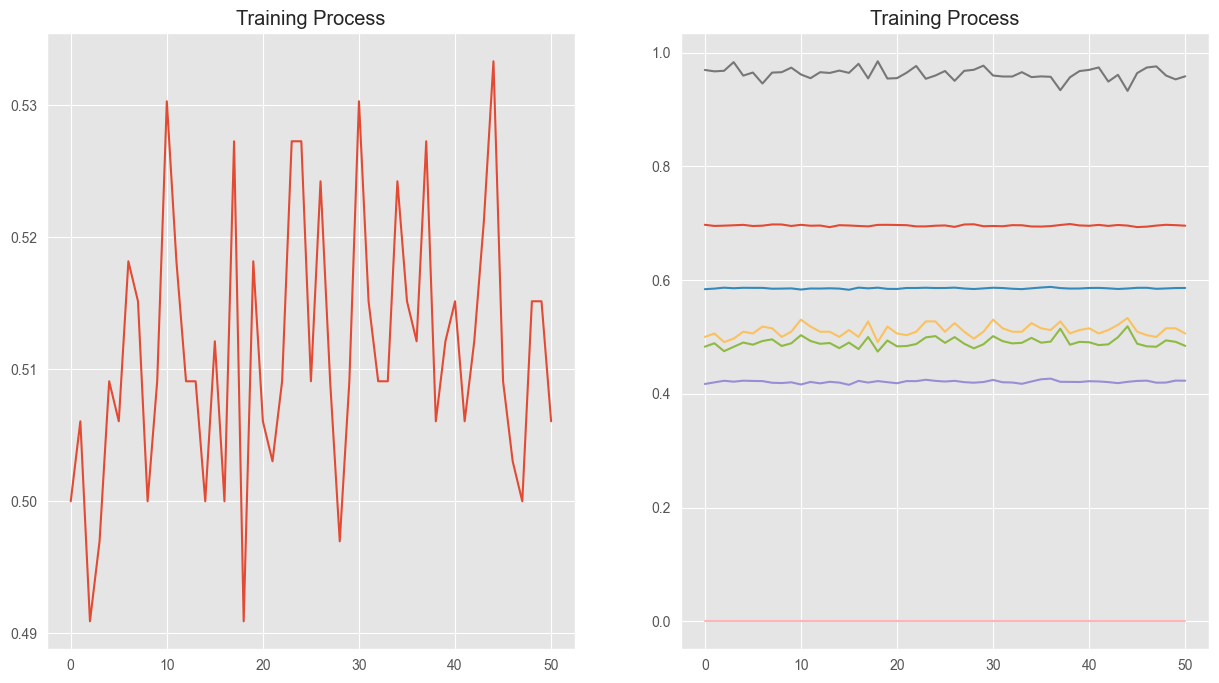

<Figure size 640x480 with 0 Axes>

In [36]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [37]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


11/11 [==============================] - 1s 18ms/step


0.4909090909090909

In [38]:
model.save_weights("model_weights_exps_gan.h5") 
print("Saved model to disk")

Saved model to disk


In [39]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.4909090909090909
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.43      0.56       242
           1       0.29      0.65      0.40        88

    accuracy                           0.49       330
   macro avg       0.53      0.54      0.48       330
weighted avg       0.64      0.49      0.52       330

Confusion Matrix:
[[105 137]
 [ 31  57]]


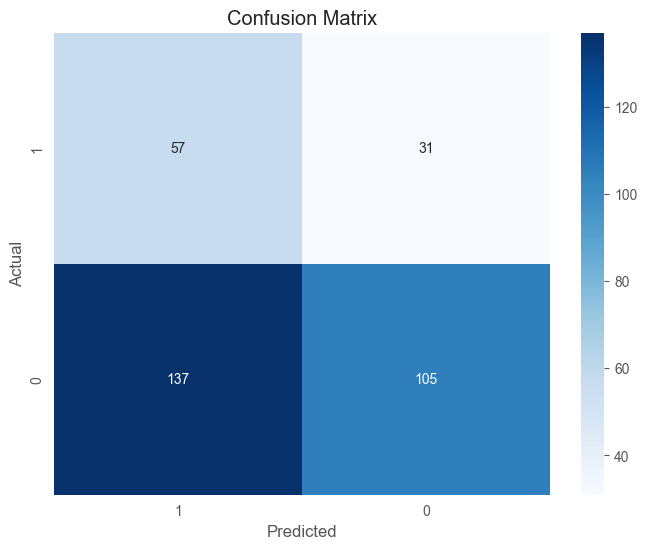

In [40]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

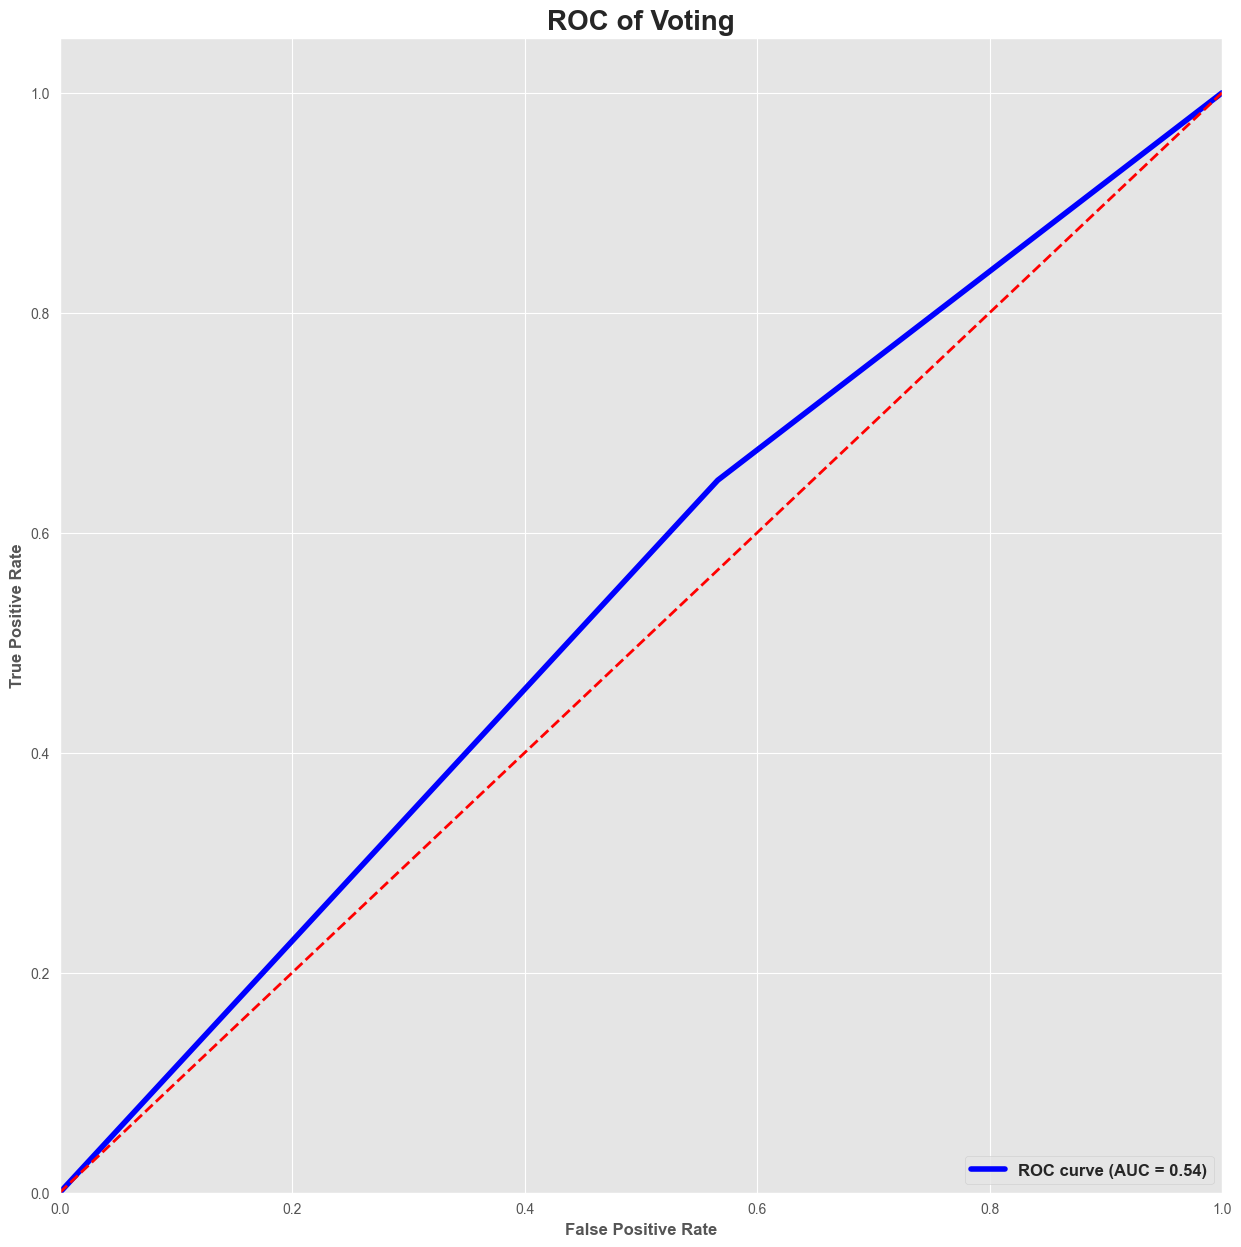

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [42]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [ ]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    